We will try to do latent semantic analysis(LSA)潛在語義分析 on restaurant comment passage, which involved using PCA to finding hidden structure in text and do classification and clustering. Our mission is identify the topic of the talk and create a model.

In [1]:
from sklearn.preprocessing import Normalizer

# scikit-learn Kmeans clustering module
from sklearn.cluster import KMeans
import pandas as pd
# NLTK sentence tokenizer
from nltk.tokenize import sent_tokenize

# feature extract module(later involved TruncatedSVD)
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

url = "https://github.com/PacktPublishing/Feature-Engineering-Made-Easy/raw/master/data/7282_1.csv"
hotel_reviews = pd.read_csv(url)

In [2]:
hotel_reviews.shape

(35912, 19)

In [3]:
hotel_reviews.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN


We only focus on US comments and ignore other languages.

<Axes: xlabel='longitude', ylabel='latitude'>

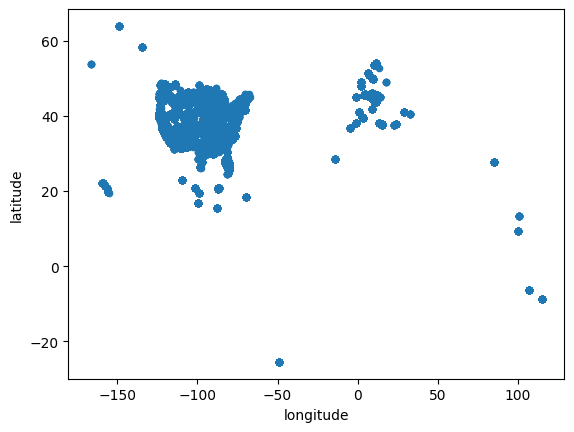

In [4]:
# comment location graph
hotel_reviews.plot.scatter(x='longitude', y='latitude')

<Axes: xlabel='longitude', ylabel='latitude'>

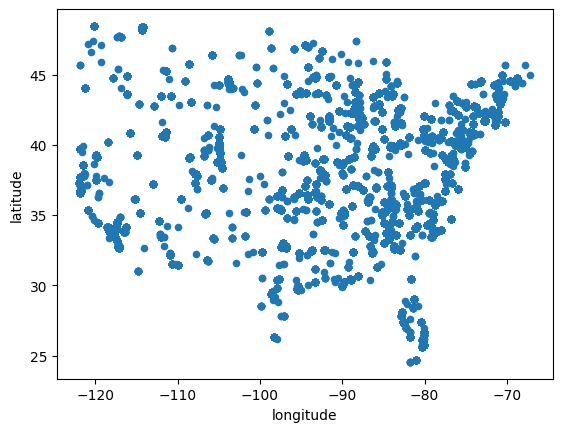

In [5]:
# focus only US comments
hotel_reviews = hotel_reviews[((hotel_reviews['latitude'] <= 50.0) & (hotel_reviews['latitude'] >= 24.0)) &
                              ((hotel_reviews['longitude'] <= -65.0) & (hotel_reviews['longitude'] >= -122.0))]

hotel_reviews.plot.scatter(x='longitude', y='latitude')

Seems like US map.

In [6]:
hotel_reviews.shape

(30692, 19)

In [7]:
# we divide topic according to theme of sentence instead of whole passage of comment, because we will talk about different
# aspects in 1 comment.

texts = hotel_reviews['reviews.text']
# we chop passage to sentence using NLTK sent_tokenize function
sent_tokenize("hello! I am Sinan. How are you??? I am fine")

['hello!', 'I am Sinan.', 'How are you???', 'I am fine']

In [10]:
from functools import reduce
# we will call sent tokenize on every comment and create a sentences list to include all sentences.
sentences = reduce(lambda x, y: x + y, texts.apply(lambda x: sent_tokenize(str(x))))

# total sentence 
len(sentences)

118151

In [16]:
# we use a TfidfVectorizer create a file word matrix
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
tfidf_transformed = tfidf.fit_transform(sentences)
tfidf_transformed

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1180275 stored elements and shape (118151, 280901)>

In [17]:
# try fitting with PCA
PCA(n_components=1000).fit(tfidf_transformed)

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

It suggest us to use singular value decomposition SVD(奇異值分解) matrix method, when data are centered instead of sparse, we can use PCA.

# SVD and PCA main component
- we need to check whether SVD and PCA give the same main components.

In [19]:
# import iris dataset
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

iris = load_iris()

# split data and target
iris_X, iris_y = iris.data, iris.target

X_centered = StandardScaler(with_std=False).fit_transform(iris_X)
X_scaled = StandardScaler().fit_transform(iris_X)

# create a SVD and PCA instance, check whether results are same
svd = TruncatedSVD(n_components=2)
pca = PCA(n_components=2)

In [20]:
# Comparing Original, centered and scaled version of iris data, using SVD and PCA.

# Original dataset
# check whether the result of minus one to another near 0.
print((pca.fit(iris_X). components_ - svd.fit(iris_X).components_).mean())

0.12987820426502983


Not near 0, different matrix.

In [21]:
# centered dataset
print((pca.fit(X_centered).components_ - svd.fit(X_centered).components_).mean())

-3.469446951953614e-17


Near 0, same matrix.

In [22]:
# scaled dataset
print((pca.fit(X_scaled).components_ - svd.fit(X_scaled).components_).mean())

-1.3877787807814457e-17


Near 0, also same.

In [23]:
# SVD return the same components after scaling as PCA, but not on the original data.
svd = TruncatedSVD(n_components=1000)
svd.fit(tfidf_transformed)

TruncatedSVD(n_components=1000)

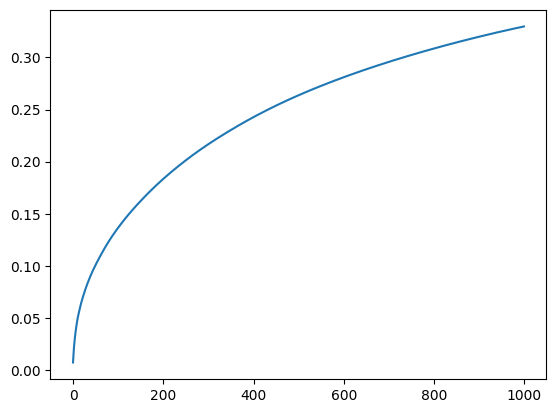

In [26]:
import matplotlib.pyplot as plt
import numpy as np
# plotting scatter plot as PCA for main component variance ratio
plt.plot(np.cumsum(svd.explained_variance_ratio_))

We can see that 1000 main components explained nearly 30% variance ratio.

Latent Sementic Analysis is a feature extraction tool, we first need TF-IDF vectorize, then using PCA(here because the text are sparse, we use SVD), finally normalize the data.

In [28]:
from sklearn.pipeline import Pipeline
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
svd = TruncatedSVD(n_components=10) # will extract 10 "topics"
normalizer = Normalizer() # will give each document a unit norm
lsa = Pipeline(steps=[('tfidf', tfidf), ('svd', svd), ('normalizer', normalizer)])

# fit and transform data
lsa_sentences = lsa.fit_transform(sentences)
lsa_sentences.shape

(118151, 10)

Matrix have 118151 rows and 10 cols, 10 cols means the 10 PCA/ SVD components, now we can use K_means clustering on lsa_sentences

In [29]:
cluster = KMeans(n_clusters=10)
cluster.fit(lsa_sentences)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10)

We use 10 as both KMeans and PCA, but this is not a must. We can use more cols in SVD, the 10 clusters means: We think there are 10 topics in the people's comment, please divide each sentences to one of the topics.

In [32]:
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', n_clusters=10, n_init=10)

We predict and fit the file-word matrix(shape:118151,280901), then have the same operation on latent semantic analysis matrix(shape: 118151, 10), and compare the result.

In [33]:
%%timeit
# original (118151, 280901) dataset speed
cluster.fit(tfidf_transformed)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


31.9 s ± 3.08 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
%%timeit
# count time for K means
cluster.predict(tfidf_transformed)

43.2 ms ± 6.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
%%timeit
# LSA (118151, 19) dataset time
cluster.fit(lsa_sentences)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

2.48 s ± 322 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can see LSA are much faster than original tfidf dataset. Now we count time to the LSA predict function.

In [36]:
%%timeit
# KMean cluster count time on LSA predict
cluster.predict(lsa_sentences)

4.31 ms ± 413 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
# Now change the text as cluster distance space, each row represent 1 observation value.
cluster.transform(lsa_sentences).shape

(118151, 10)

In [38]:
predicted_cluster = cluster.predict(lsa_sentences)
predicted_cluster

array([7, 7, 7, ..., 0, 7, 4], dtype=int32)

In [40]:
# Now we can get the distribution of topics, the code as below
pd.Series(predicted_cluster).value_counts(normalize=True) # create DataFrame of text and predict topics
texts_df = pd.DataFrame({'text':sentences, 'topic': predicted_cluster})

texts_df.head()

,text,topic
0,to share your opinion of this businesswith YP ...,7
1,to share your opinion of this businesswith YP ...,7
2,to share your opinion of this businesswith YP ...,7
3,"We had a wonderful, relaxing time.",1
4,The staff were completely attentive and accomm...,2


In [41]:
print("Top terms per cluster:")
original_space_centroids = svd.inverse_transform(cluster.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = lsa.steps[0][1].get_feature_names_out()
for i in range(10):
    print("Cluster %d:" %i)
    print(', '.join([terms[ind] for ind in order_centroids[i, :5]]))
    print(lsa.steps[0][1])

Top terms per cluster:
Cluster 0:
nice, room, hotel, staff, breakfast
TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
Cluster 1:
hotel, room, good, great, stay
TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
Cluster 2:
staff, friendly, staff friendly, helpful, friendly helpful
TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
Cluster 3:
stay, hotel, good, enjoyed stay, enjoyed
TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
Cluster 4:
room, room clean, hotel, good, bed
TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
Cluster 5:
hotel, recommend, recommend hotel, good, hotel clean
TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
Cluster 6:
great, location, breakfast, hotel, stay
TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
Cluster 7:
clean, room clean, rooms, clean comfortable, comfortable
TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
Cluster 8:
comfortable, bed, clean comfortable, bed comfortable, room
Tfi

We can see each cluster have different topics, in Cluster5, it talk about the recommendation of the hotel to the family and friends, in Cluster 2, it talk about the staff are friendly or not. Now we want to predict new topics.

In [43]:
# predict topics
print(cluster.predict(lsa.transform(['I definitely recommend this hotel'])))
print(cluster.predict(lsa.transform(['super friendly staff. Love it!'])))

[5]
[2]


- Good prediction, the prediction of 5 corresponded to: hotel, recommend, recommend hotel, good, hotel clean.
- The prediction of 2 corresponded to staff, friendly, staff friendly, helpful, friendly helpful.